# Model Developement: KNN for Activity Recognition


## Feature Engineering
* Idea: spectral analysis!
* We sample @ fs = 50Hz -> Assumption: tracked movements have no frequency components > 5 Hz -> we can downsample the signal by a factor M = 3! -> we need an anti aliasing filter!

AA Filter Coefficients: [ 0.00040535 -0.00035465 -0.00103265 -0.00072392  0.00098568  0.00262148
  0.00170929 -0.00219276 -0.00554828 -0.00346843  0.00429339  0.01054113
  0.00642698 -0.00779771 -0.01885992 -0.01138985  0.01377397  0.03346063
  0.02049844 -0.02549354 -0.06500515 -0.04321656  0.06204003  0.21027667
  0.31805038  0.31805038  0.21027667  0.06204003 -0.04321656 -0.06500515
 -0.02549354  0.02049844  0.03346063  0.01377397 -0.01138985 -0.01885992
 -0.00779771  0.00642698  0.01054113  0.00429339 -0.00346843 -0.00554828
 -0.00219276  0.00170929  0.00262148  0.00098568 -0.00072392 -0.00103265
 -0.00035465  0.00040535]


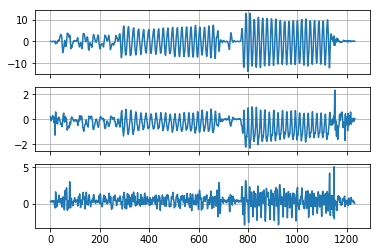

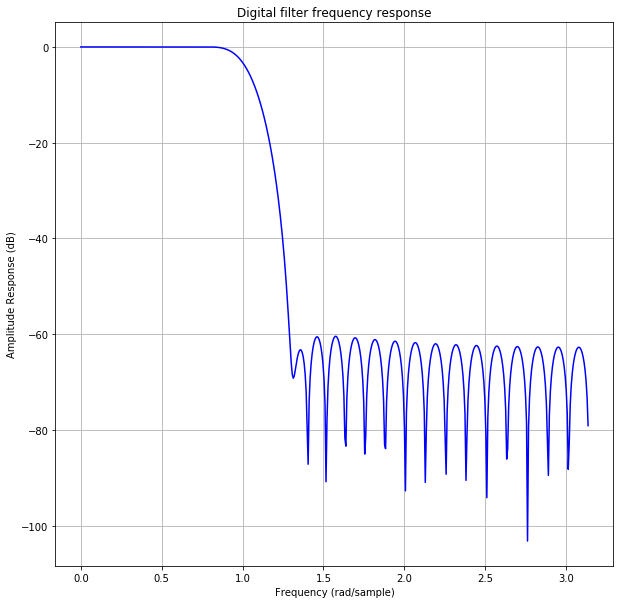

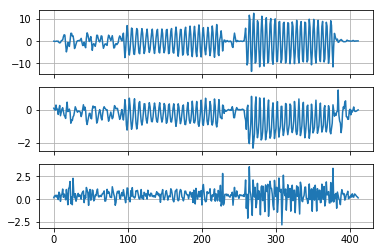

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack, signal
import pandas as pd

# load measurement data
with open('sensorData.txt', newline='\n') as dataFile:
    data = pd.read_csv(dataFile, ';')
    x = data.get_values()[:, 0]
    y = data.get_values()[:, 1]
    z = data.get_values()[:, 2]

# have a look at the data
plt.figure(figsize=(20, 20))
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x)
ax1.grid()
ax2.plot(y)
ax2.grid()
ax3.plot(z)
ax3.grid()

# design/apply anti aliasing filter and downsample the signals
M = 3  # downsampling factor
lowpass = signal.firwin(numtaps=50, cutoff=1 / M, window=('chebwin', -50))
w, H = signal.freqz(lowpass)
print ("AA Filter Coefficients:", lowpass)

x = signal.convolve(x, lowpass, mode='same')
x = x[::M]

y = signal.convolve(y, lowpass, mode='same')
y = y[::M]

z = signal.convolve(z, lowpass, mode='same')
z = z[::M]

# have a look at the magnitude response of the aa filter
plt.figure(figsize=(10, 10))
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(np.abs(H)), 'b')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.show()

plt.figure()
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x)
ax1.grid()
ax2.plot(y)
ax2.grid()
ax3.plot(z)
ax3.grid()


If we classify each second we get 50 / M = 17 samples! --> bad frequency resolution!! -> we take a Hann window for better practical frequency resolution!

17
Hann window coefficients:  [0.         0.03376389 0.13049554 0.27713082 0.45386582 0.6368315
 0.80131732 0.92510857 0.99148655 0.99148655 0.92510857 0.80131732
 0.6368315  0.45386582 0.27713082 0.13049554 0.03376389]


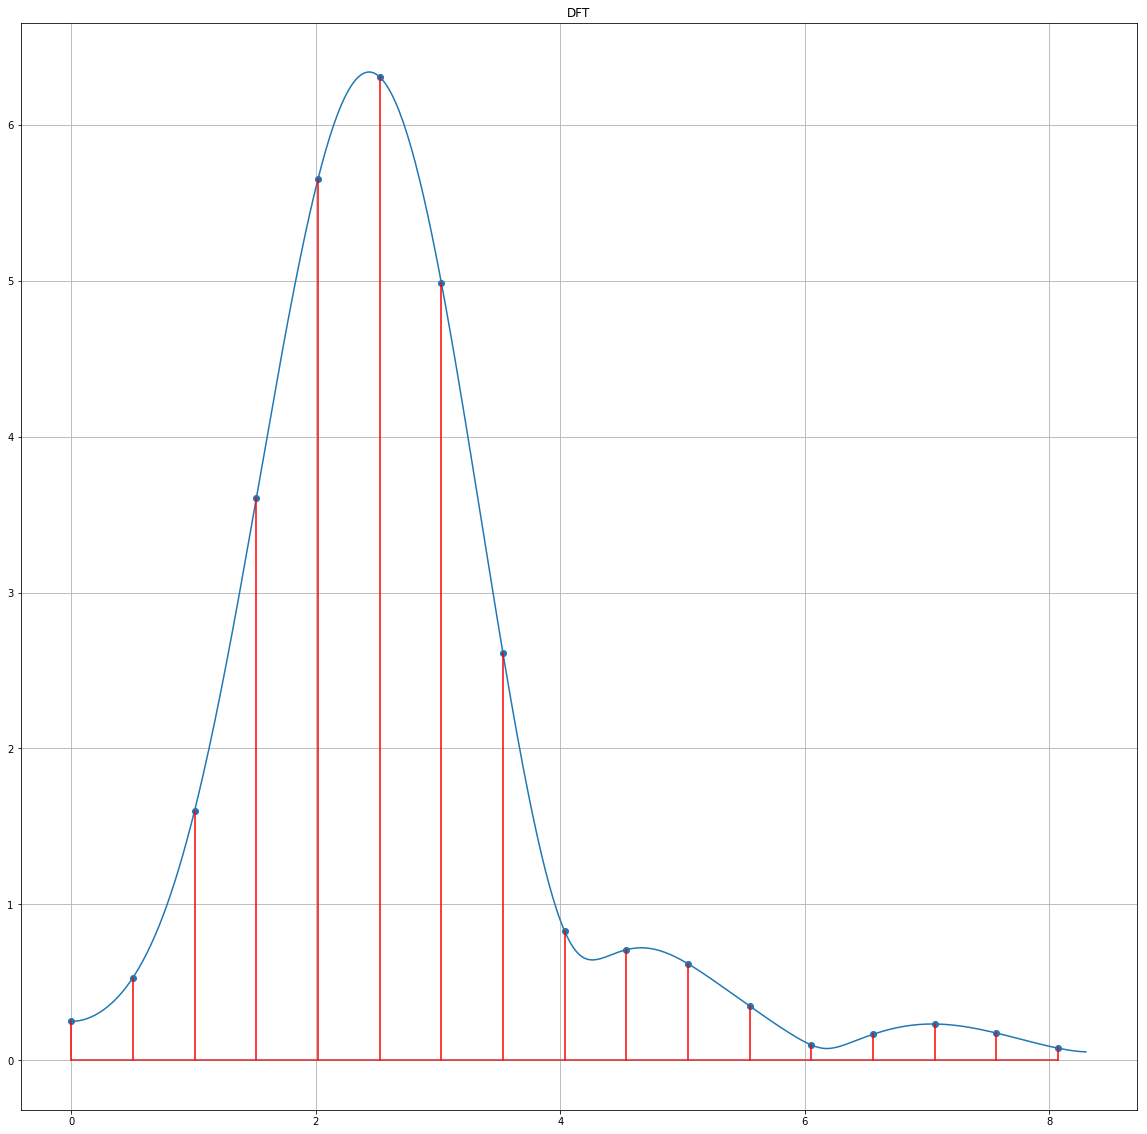

In [112]:
# sampling frequency in Hz
fs = 50 / M;

# generate and plot window
N = 17; # window length
print (N)
n = np.arange(0, N, 1)
window = signal.get_window('hann', N)
print ("Hann window coefficients: ", window)

#plt.figure(figsize=(10, 10))
#plt.plot(n, window)
#plt.title('Hann Window for DFT Computation')


# compute DFT
NDFT = 1024;
x_test = x[100:100+N] * window
X = fftpack.fft(x_test, NDFT)
X = X[: np.int(NDFT/2) - 1] # take only the onesided spectrum (for NDFT even!!!)
X *= 2 / np.sum(window) # do normalization

k = np.arange(0,NDFT/2 - 1, 1)
freq = k / (NDFT / 2) * fs / 2

plt.figure(figsize=(20, 20))
plt.plot(freq, np.abs(X))
plt.stem(freq[::31],np.abs(X)[::31], 'r')
plt.title('DFT')
plt.grid()